## Neural networks for segmentation

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [1]:
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import PIL.Image as Image
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchvision import transforms, utils
import os
import torch
from imageio import imread
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

In [2]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

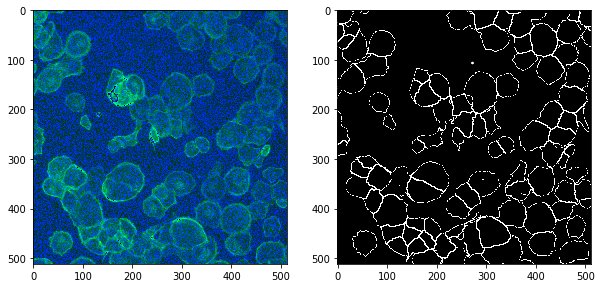

In [3]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')
plt.show()

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [4]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [5]:
model = smp.Unet('vgg19', encoder_weights='imagenet')
preprocess_input = get_preprocessing_fn('vgg19', pretrained='imagenet')

In [6]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)

cuda:3


In [7]:
IMAGES_DIR = 'BBBC018_v1_images-fixed'
IMAGES_TRAIN = os.path.join(IMAGES_DIR, 'train')
IMAGES_VAL = os.path.join(IMAGES_DIR, 'val')
IMAGES_TEST = os.path.join(IMAGES_DIR, 'test')

LABELS_DIR = 'BBBC018_v1_outlines'
LABELS_TRAIN = os.path.join(LABELS_DIR, 'train')
LABELS_VAL = os.path.join(LABELS_DIR, 'val')

In [8]:
train_csv = pd.DataFrame({'images': [os.path.join(IMAGES_DIR, 'train', x) for x in sorted(os.listdir(IMAGES_TRAIN))], 
                          'labels': [os.path.join(LABELS_DIR, 'train', x) for x in sorted(os.listdir(LABELS_TRAIN))]})

val_csv = pd.DataFrame({'images': [os.path.join(IMAGES_DIR, 'val', x) for x in sorted(os.listdir(IMAGES_VAL))], 
                        'labels': [os.path.join(LABELS_DIR, 'val', x) for x in sorted(os.listdir(LABELS_VAL))]})

test_csv = pd.DataFrame({'images': [os.path.join(IMAGES_DIR, 'test', x) for x in sorted(os.listdir(IMAGES_TEST))], 
                         'labels': None})

In [9]:
class CellsDataset(Dataset):

    def __init__(self, csv, transform=None, test=False):
        self.samples = csv
        self.transform = transform
        self.test = test

    def __getitem__(self, idx):
        img_name = os.path.join(self.samples.iloc[idx, 0])
        img = np.array(imread(img_name))[..., 1]
        img = np.dstack([img, img, img])
        if not self.test:
            mask_name = self.samples.iloc[idx, 1]
            mask = np.array(imread(mask_name))
        
        sample = dict()
        sample['image'] = img
        if not self.test:
            sample['mask'] = mask
        else:
            sample['mask'] = np.zeros_like(img)

        if self.transform:
            sample = self.transform(sample)
            
        image, mask = sample['image'], sample['mask']
        image = np.moveaxis(image, -1, 0)
        mask = np.moveaxis(mask, -1, 0)
        
        return torch.FloatTensor(image), torch.FloatTensor(mask)
    
    def __len__(self):
        return len(self.samples)

In [10]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose, RandomCrop, ChannelShuffle,
    RGBShift, RandomGamma, DualTransform, RandomScale, RandomBrightnessContrast
)

def strong_aug(p=0.5):
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            MotionBlur(p=0.4),
            MedianBlur(blur_limit=3, p=0.4),
            Blur(blur_limit=3, p=0.4),
        ], p=0.6),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.4),
        OneOf([
            OpticalDistortion(p=0.5),
            GridDistortion(p=0.5),
            IAAPiecewiseAffine(p=0.5),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),
        ], p=0.3),
        HueSaturationValue(p=0.5),
    ], p=p)

augmentation_whole = strong_aug(p=0.7)

In [11]:
def train_transform(sample):
    data = {'image': sample['image'],
            'mask': sample['mask']}
    sample = augmentation_whole(**data)
    sample['image'] = preprocess_input(sample['image'])
    sample['image'] = sample['image'].copy()
    if len(sample['mask'].shape) < 3:
        sample['mask'] = sample['mask'][..., np.newaxis]  
    sample['mask'] = np.where(sample['mask'] > 0, 1, 0)
    return sample

def val_transform(sample):
    data = {'image': sample['image'],
            'mask': sample['mask']}
    sample['image'] = preprocess_input(sample['image'])
    sample['image'] = sample['image'].copy()
    if len(sample['mask'].shape) < 3:
        sample['mask'] = sample['mask'][..., np.newaxis]
    sample['mask'] = np.where(sample['mask'] > 0, 1, 0)
    return sample

In [12]:
train_dataset = CellsDataset(train_csv, train_transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

val_dataset = CellsDataset(val_csv, val_transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0)

test_dataset = CellsDataset(test_csv, val_transform, test=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [13]:
image, mask = train_dataset[0]
image = np.moveaxis(image.numpy(), 0, -1)
mask = mask.numpy()[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


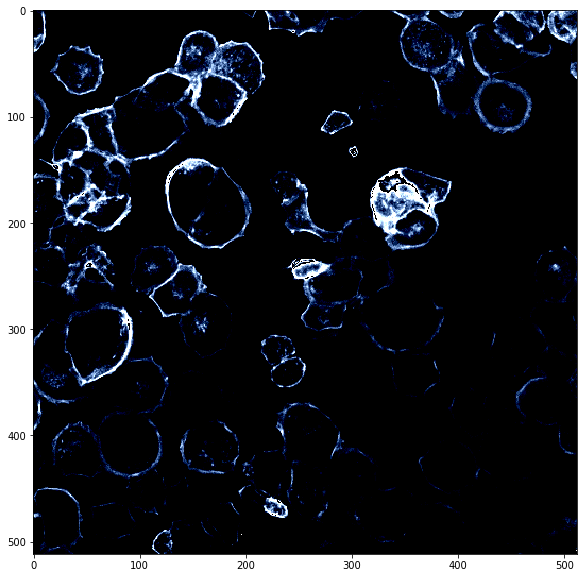

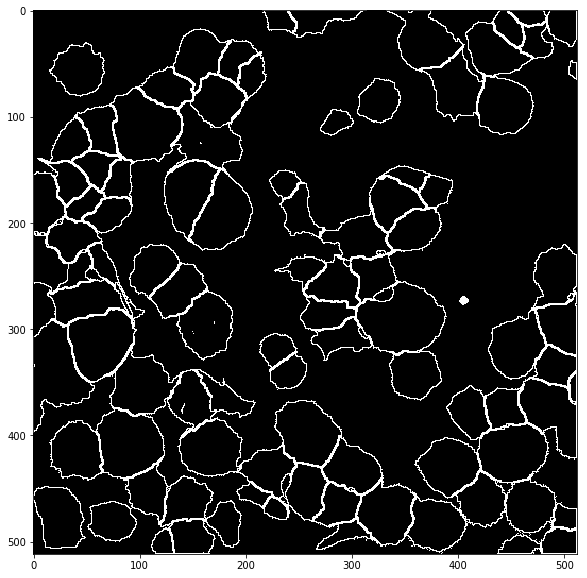

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.show()

In [15]:
loss = smp.utils.losses.BCEDiceLoss(eps=1.)
metrics = [
    smp.utils.metrics.IoUMetric(eps=1.),
    smp.utils.metrics.FscoreMetric(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3}, 
    
    # decrease lr for encoder in order not to permute 
    # pre-trained weights with large gradients on training start
    {'params': model.encoder.parameters(), 'lr': 1e-4},  
])

In [16]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [17]:
max_score = 0
epochs = 80

for i in range(0, epochs):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou']:
        max_score = valid_logs['iou']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 7/7 [00:01<00:00,  6.34it/s, bce_dice_loss - 2.47, iou - 0.07623, f-score - 0.1408] 
Model saved!

Epoch: 1
valid: 100%|██████████| 7/7 [00:00<00:00, 11.95it/s, bce_dice_loss - 1.729, iou - 0.1293, f-score - 0.2284]
Model saved!

Epoch: 2
valid: 100%|██████████| 7/7 [00:00<00:00, 13.82it/s, bce_dice_loss - 1.067, iou - 0.1984, f-score - 0.3299] 
Model saved!

Epoch: 3
valid: 100%|██████████| 7/7 [00:00<00:00,  9.73it/s, bce_dice_loss - 0.9478, iou - 0.2238, f-score - 0.3642]
Model saved!

Epoch: 4
valid: 100%|██████████| 7/7 [00:00<00:00, 10.72it/s, bce_dice_loss - 0.9341, iou - 0.2378, f-score - 0.3818]
Model saved!

Epoch: 5
valid: 100%|██████████| 7/7 [00:00<00:00, 10.72it/s, bce_dice_loss - 0.8479, iou - 0.2598, f-score - 0.4085]
Model saved!

Epoch: 6
valid: 100%|██████████| 7/7 [00:00<00:00, 11.27it/s, bce_dice_loss - 0.8298, iou - 0.2618, f-score - 0.4106]
Model saved!

Epoch: 7
valid: 100%|██████████| 7/7 [00:00<00:00, 12.79it/s, bce_dice_loss 

valid: 100%|██████████| 7/7 [00:00<00:00, 10.06it/s, bce_dice_loss - 0.7313, iou - 0.3206, f-score - 0.4763]

Epoch: 70
valid: 100%|██████████| 7/7 [00:00<00:00, 12.93it/s, bce_dice_loss - 0.7259, iou - 0.3279, f-score - 0.4844]
Model saved!

Epoch: 71
valid: 100%|██████████| 7/7 [00:00<00:00, 13.54it/s, bce_dice_loss - 0.7293, iou - 0.3277, f-score - 0.4843]

Epoch: 72
valid: 100%|██████████| 7/7 [00:00<00:00, 12.50it/s, bce_dice_loss - 0.7306, iou - 0.3216, f-score - 0.4771]

Epoch: 73
valid: 100%|██████████| 7/7 [00:00<00:00, 10.62it/s, bce_dice_loss - 0.7289, iou - 0.3207, f-score - 0.4763]

Epoch: 74
valid: 100%|██████████| 7/7 [00:00<00:00, 12.63it/s, bce_dice_loss - 0.7273, iou - 0.3247, f-score - 0.4817]

Epoch: 75
valid: 100%|██████████| 7/7 [00:00<00:00, 11.59it/s, bce_dice_loss - 0.7261, iou - 0.3278, f-score - 0.4848]

Epoch: 76
valid: 100%|██████████| 7/7 [00:00<00:00, 10.02it/s, bce_dice_loss - 0.7261, iou - 0.3299, f-score - 0.4874]
Model saved!

Epoch: 77
valid: 100%|██

In [19]:
best_model = torch.load('./best_model.pth')

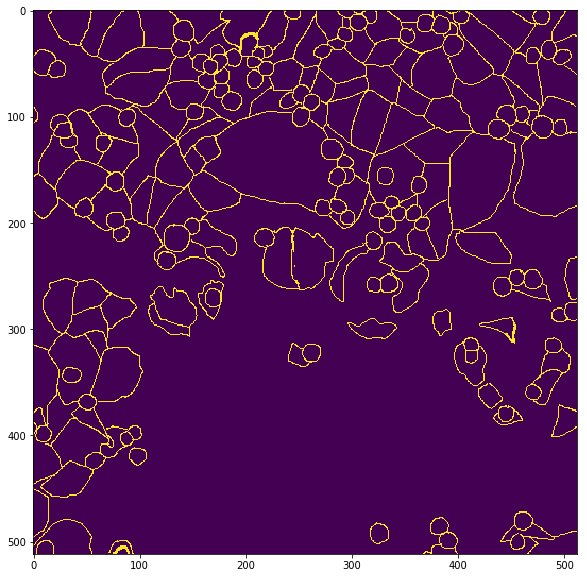

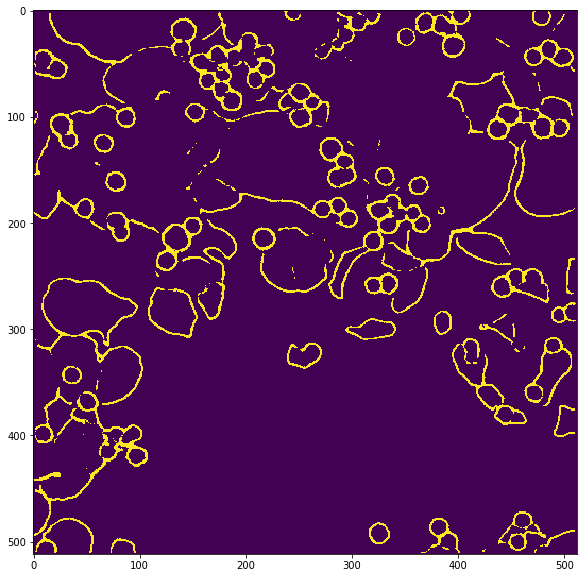

In [18]:
scores = []
threshold = 0.5
model.eval()
for i in range(len(val_dataset)):
    input = val_dataset[i][0][None, ...].to(device)
    prediction = model.predict(input).cpu().numpy()
    prediction = np.where(prediction > threshold, 1, 0)
    target = np.where(val_dataset[i][1].numpy() > 0, 1, 0)
    score = calc_iou(prediction, target)
    scores += [score]
    
plt.figure(figsize=(10, 10))
plt.imshow(target[0])
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(prediction[0, 0, ...])
plt.show()

In [19]:
print('Mean IoU value on validation dataset:', np.mean(scores))

Mean IoU value on validation dataset: 0.32379916608946696


# Predict masks

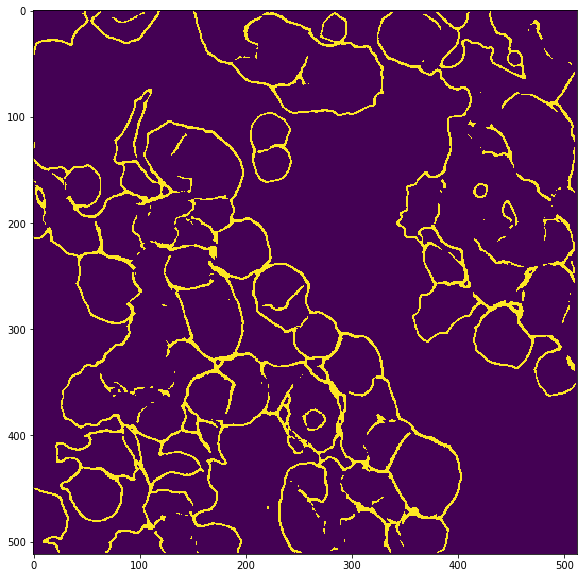

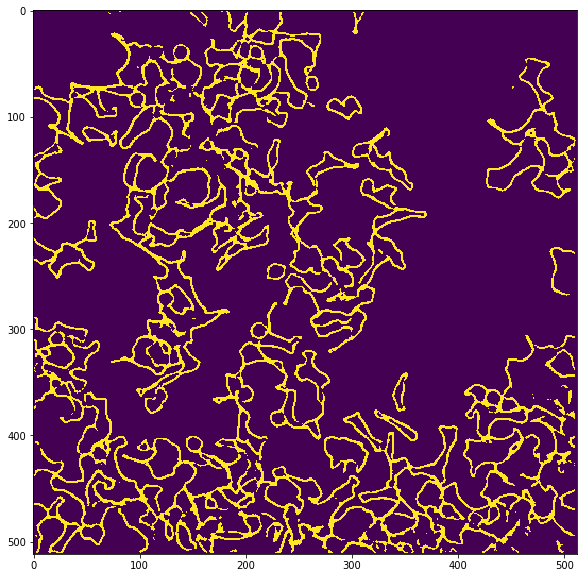

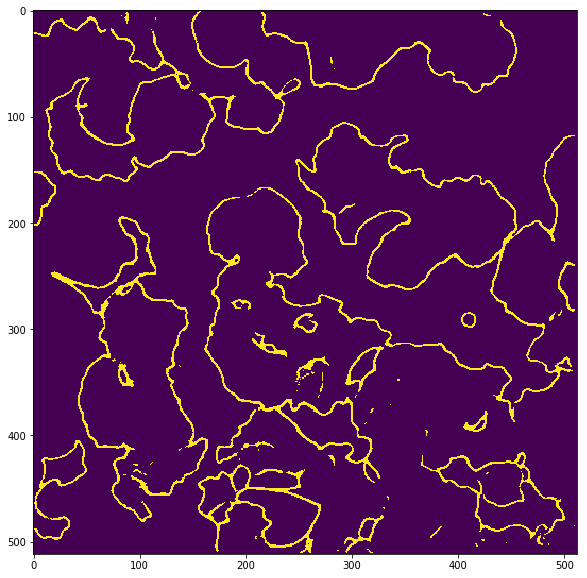

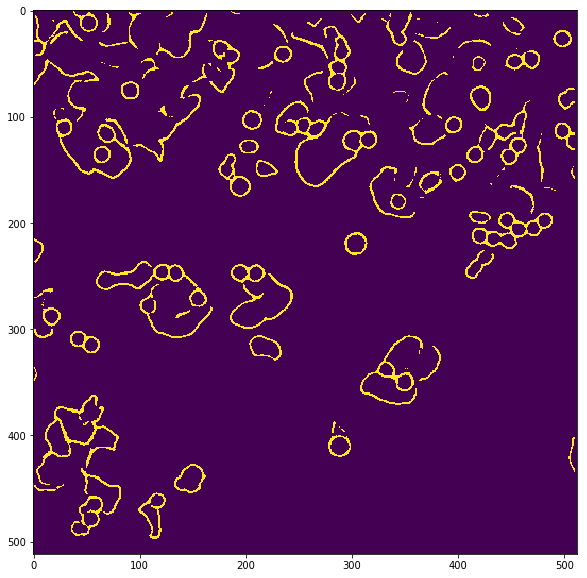

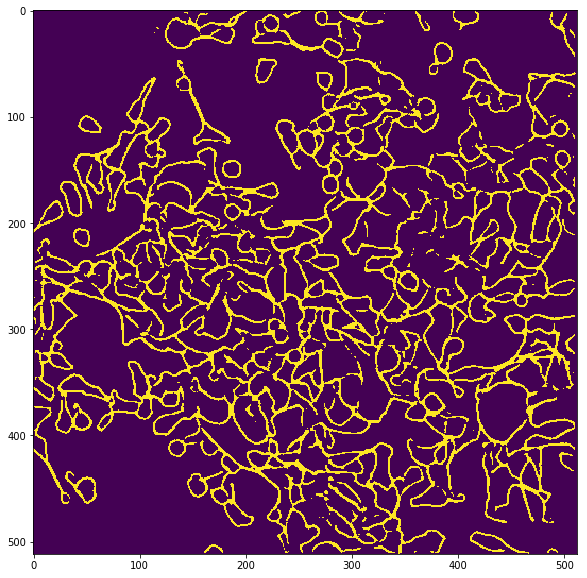

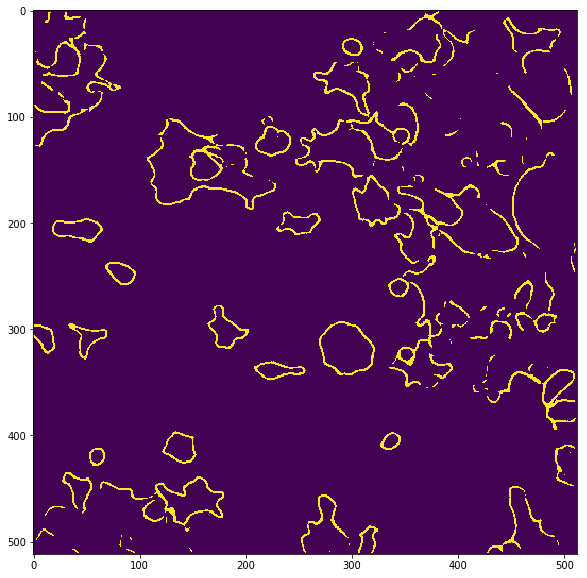

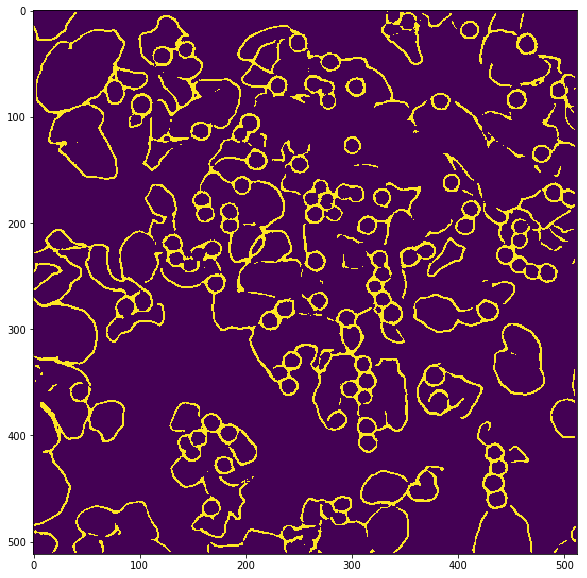

In [22]:
model.eval()
images = []
for i in range(len(test_dataset)):
    input = test_dataset[i][0][None, ...].to(device)
    prediction = model.predict(input).cpu().numpy()
    prediction = np.where(prediction > threshold, 1, 0)
    images += [prediction]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(prediction[0, 0, ...])
    plt.show()

In [43]:
final_masks = np.empty((0, 512, 512))
for image in images:
    final_masks = np.vstack([final_masks, image[0, 0, ...][None, ...]])

In [53]:
np.save('masks.npy', final_masks)

Here I used the implementation of UNet architecture from https://github.com/qubvel/segmentation_models.pytorch. In this library there are several popular segmentation models with a lot of backbones. Also there is a code for training wrapper.